In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
import wandb
from torch import optim
from tqdm.auto import tqdm, trange
from embedded_dataset import ItemsDatasetEmbedded, split_list
from torch.nn import MSELoss
from lfm import LFM, MaskedMSELoss
from scalf import custom_collate_fn, SemanticLatentLite


In [2]:
review_30 = pd.read_csv('review_30.csv', index_col=0)
item_30 = pd.read_csv('item_30.csv', index_col=0)
review_train = pd.read_csv('review_train.csv', index_col=0)
review_test = pd.read_csv('review_test.csv', index_col=0)

In [3]:
review_ratings = review_30[['user_id', 'gmap_id', 'rating']].copy()
item_user_df = review_ratings.pivot_table(index='gmap_id', columns='user_id', values='rating', aggfunc='mean')
mask = torch.tensor(item_user_df.notnull().to_numpy())
item_user_matrix = torch.tensor(item_user_df.fillna(0).to_numpy()).float()
n_item, n_user = item_user_matrix.shape
item_all = review_ratings['gmap_id'].unique().tolist()
user_all = review_ratings['user_id'].unique().tolist()

review_ratings_test = review_test[['user_id', 'gmap_id', 'rating']].copy()
item_user_df_test = review_ratings_test.pivot_table(index='gmap_id', columns='user_id', values='rating', aggfunc='mean')
item_user_df_test = item_user_df_test.reindex(index=item_all, columns=user_all).sort_index(ascending=True).sort_index(axis=1, ascending=True)
item_user_matrix_test = torch.tensor(item_user_df_test.fillna(0).to_numpy()).float()
mask_test = torch.tensor(item_user_df_test.notnull().to_numpy())

review_ratings_train = review_train[['user_id', 'gmap_id', 'rating']].copy()
item_user_df_train = review_ratings_train.pivot_table(index='gmap_id', columns='user_id', values='rating', aggfunc='mean')
item_user_df_train = item_user_df_train.reindex(index=item_all, columns=user_all).sort_index(ascending=True).sort_index(axis=1, ascending=True)
item_user_matrix_train = torch.tensor(item_user_df_train.fillna(0).to_numpy()).float()
mask_train = torch.tensor(item_user_df_train.notnull().to_numpy())

global_bias = torch.mean(item_user_matrix[mask_train]).item()

In [4]:
masked_mse= MaskedMSELoss()

In [5]:
item_user_df

user_id,0,1,2,3,4,5,6,7,8,9,...,22632,22633,22634,22635,22636,22637,22638,22639,22640,22641
gmap_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## SVD

In [10]:
review_train

,user_id,rating,text,gmap_id,time,wc
2578928,20585,3.0,They removed all of the items I normally eat o...,495,1621709002844,12
19389956,17250,5.0,Even open until 10pm! Yay! Delicious and reaso...,10543,1608004977360,10
12938559,20603,5.0,"Great atmosphere, food, drinks and staff! Our ...",6036,1572144748207,15
19373719,16162,5.0,Friendly staff and yummy food. I LOVE the kid...,10534,1571708909220,25
2554799,18930,4.0,Nice Park,477,1453234630307,2
...,...,...,...,...,...,...
5521214,5185,4.0,Good coneys but I like National better,1044,1562621696931,7
8797275,1139,1.0,They plain and flat out don't care about the p...,2973,1503412688980,19
5882203,9969,5.0,A wise man by the name of deadpool once said.....,1238,1493749665745,11
14712257,16980,4.0,Conveniently located small neighborhood or loc...,7363,1531162656533,45


In [36]:
from surprise import Dataset, Reader
from surprise import BaselineOnly
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy


reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(review_train[['user_id', 'gmap_id', 'rating']], reader)
data_train = data_train.build_full_trainset()
base_model = SVD()
base_model.fit(data_train)

In [37]:
data_test = Dataset.load_from_df(review_test[['user_id', 'gmap_id', 'rating']], reader)
data_test = data_test.build_full_trainset()
predictions = base_model.test(data_test.build_testset())
score = accuracy.mse(predictions)
print(score)

MSE: 0.9210
0.9210250068354455


## LFM

In [8]:
lfm_test = LFM(n_item, n_user, 768, global_bias)
lfm_test.load_state_dict(torch.load('models/lfm_model.pt'))
lfm_test.eval()
y_test = item_user_matrix_test
items_test = torch.arange(n_item)
users_test = torch.arange(n_user)
y_pred = lfm_test(items_test, users_test)
loss = masked_mse(y_pred, y_test, mask_test)**0.5
print('cross validation loss of LFM:', loss.item())

cross validation loss of LFM: 1.0818188190460205


## SCALF

In [14]:
sll_test = SemanticLatentLite(n_item, n_user, 768, 8)
sll_test.load_state_dict(torch.load('models/sll_model.pt'))
sll_test.eval()
y_test = item_user_matrix_test
item_test = torch.tensor(range(n_item))
user_test = torch.tensor(range(n_user))
y_pred = sll_test.predict(item_test, user_test)
loss = masked_mse(y_pred, y_test, mask_test)**0.5
print('cross validation loss of scalf:', loss.item())

cross validation loss of scalf: 1.1093969345092773


In [54]:
A = torch.tensor([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
])
B = torch.tensor([
    [1],
    [2],
    [3],
])
A+B.T

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [50]:
review_train[review_train['user_id'] == 2]

,user_id,rating,text,gmap_id,time,wc
5880226,2,3.0,It's Meijer. There's not much to report. The...,1237,1550801661215,19
13434033,2,5.0,The groomers handle my crazy dogs for their na...,6384,1550802187246,52
7558456,2,5.0,"These lanes are well lit, and extremely well k...",2164,1557688703414,23
14283217,2,3.0,"Who doesn't love a 2,000 calorie meal full of ...",7061,1552834315894,39
11187413,2,4.0,"The girls that work there were super friendly,...",4732,1537667375649,38
11397701,2,4.0,Nice little theater! We went here for my son's...,4897,1546784465579,30
19963407,2,3.0,Typical shopping mall. It looks nice since it...,10893,1537666809289,10
1676316,2,2.0,The place wasn't very clean. The food was goo...,124,1582149191432,55
19876468,2,4.0,It's always a nice time if you're looking for ...,10856,1550801375920,28
13976941,2,2.0,I've never actually eaten any food here. I've...,6797,1546784110067,37


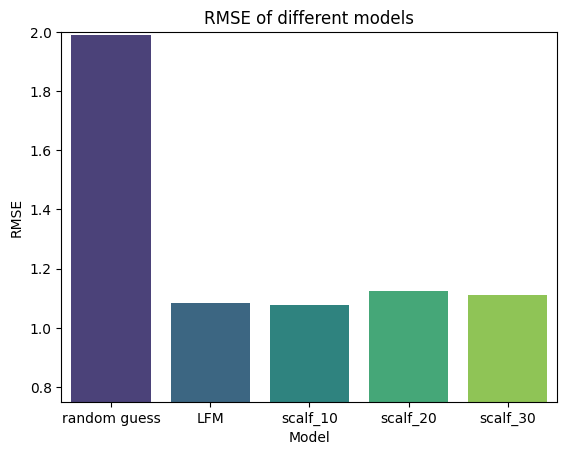

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

name = ['random guess', 'LFM', 'scalf_10', 'scalf_20', 'scalf_30']
value = [1.9911417961120605, 1.0818188190460205, 1.0779768228530884, 1.1249221563339233, 1.1093969345092773]
sns.barplot(x=name, y=value, hue=name, palette='viridis')
plt.ylim(0.75, 2)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('RMSE of different models')
plt.show()

In [10]:
random_guess = torch.rand(n_item, n_user)*4+1
loss = masked_mse(random_guess, y_test, mask_test)**0.5
print('cross validation loss of random guess:', loss.item())

cross validation loss of random guess: 1.9911417961120605
